In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

***import image***

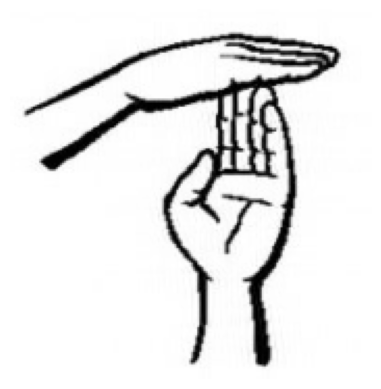

Image shape: (178, 174)


In [2]:
I = cv2.imread("sample1.png", 1)
I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
plt.imshow(I, cmap="gray")
plt.axis("off")
plt.show()
print("Image shape:", I.shape)

***Base function***

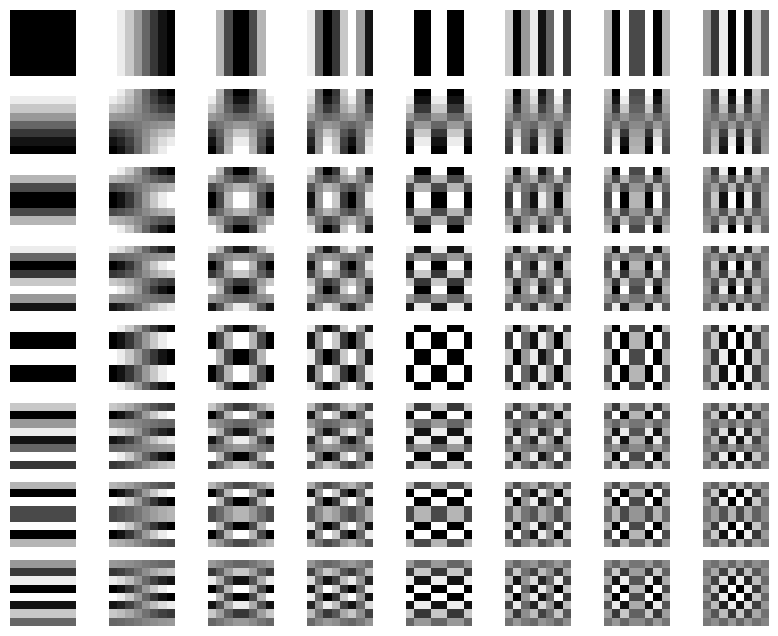

In [3]:
coef_base = np.zeros((8, 8, 8, 8))
for u in range(8):
    for v in range(8):
        for x in range(8):
            for y in range(8):
                coef_base[u, v, x, y] = np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
fig, axes = plt.subplots(8, 8, figsize=(10, 8))
for u in range(8):
    for v in range(8):
        axes[u, v].imshow(coef_base[u, v], cmap="gray")
        axes[u, v].axis("off")
plt.show()

***Base quantizition***

In [4]:
def QQC(degree):
    newQ = np.zeros((8, 8), dtype=np.uint8)
    if 1 < degree < 50:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip((50 / degree) * Q[i, j], 0, 255)
        return newQ
    elif 50 < degree < 100:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip(((100 - degree) / 50) * Q[i, j], 0, 255)
        return newQ
    elif degree == 50:
        return Q
    else:
        return "sorry but not possible"

Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])


***Apply the DCT***

In [5]:
num_blocks = (I.shape[0] // 8, I.shape[1] // 8)
blocks = np.empty((num_blocks[0], num_blocks[1], 8, 8))
for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
    for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
        blocks[i, j] = I[k:k + 8, l:l + 8]
width, height, _, _ = blocks.shape

In [6]:
def DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr)
    g_x = np.subtract(np.copy(arr), 128)
    for row in range(width):
        for column in range(height):
            for u in range(8):
                au = 1/2
                if u == 0: au = np.sqrt(1 / 8)
                for v in range(8):
                    sumGx = 0
                    av = 1/2
                    if v == 0: av = np.sqrt(1 / 8)
                    for x in range(8):
                        for y in range(8):
                            sumGx += g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = au * av * sumGx
    return result

dctM = DCT(blocks)

In [7]:
def quantizition(arr, Q):
    quant = QQC(Q)
    finalStep = np.zeros_like(arr)
    for i in range(width):
        for j in range(height):
            for x in range(8):
                for y in range(8):
                    finalStep[i, j, x, y] = round(arr[i, j, x, y] * quant[x, y])
    return finalStep

qun = quantizition(dctM, 50)

***reconstruct by 30, 50 and 70***

In [8]:
def energy_left(arr, energy):
    qunP = np.copy(arr)
    leftEnergy = round(8*energy/100)
    for i in range(width):
        for j in range(height):
            qunP[i, j, leftEnergy:] = 0
            qunP[i, j, :, leftEnergy:] = 0
    return qunP
newImg_70 = energy_left(qun, 70)
newImg_50 = energy_left(qun, 50)
newImg_30 = energy_left(qun, 30)

***Apply the IDCT***

In [9]:
def inv_DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr)
    g_x = np.copy(arr)
    for row in range(width):
        for column in range(height):
            for u in range(8):
                au = 1/2
                if u == 0: np.sqrt(1 / 8)
                for v in range(8):
                    sumGx = 0
                    av = 1/2
                    if v == 0: av =  np.sqrt(1 / 8)
                    for x in range(8):
                        for y in range(8):
                            sumGx = sumGx + g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(
                                ((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = au * av * sumGx
    result += 128
    return result.astype(np.uint8)

In [10]:
inv_dct_30 = inv_DCT(np.array(newImg_30))
inv_dct_50 = inv_DCT(np.array(newImg_50))
inv_dct_70 = inv_DCT(np.array(newImg_70))
inv_dct = inv_DCT(np.array(qun))


In [11]:
def restord(img):
    cp = np.copy(img)
    new_Img = np.empty((I.shape[0], I.shape[1]), dtype = np.uint8)
    for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
        for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
            new_Img[k:k + 8, l:l + 8] = cp[i, j]
    return new_Img

In [12]:
new_Img = restord(inv_dct)
new_Img_30 = restord(inv_dct_30)
new_Img_50 = restord(inv_dct_50)
new_Img_70 = restord(inv_dct_70)

***Result***

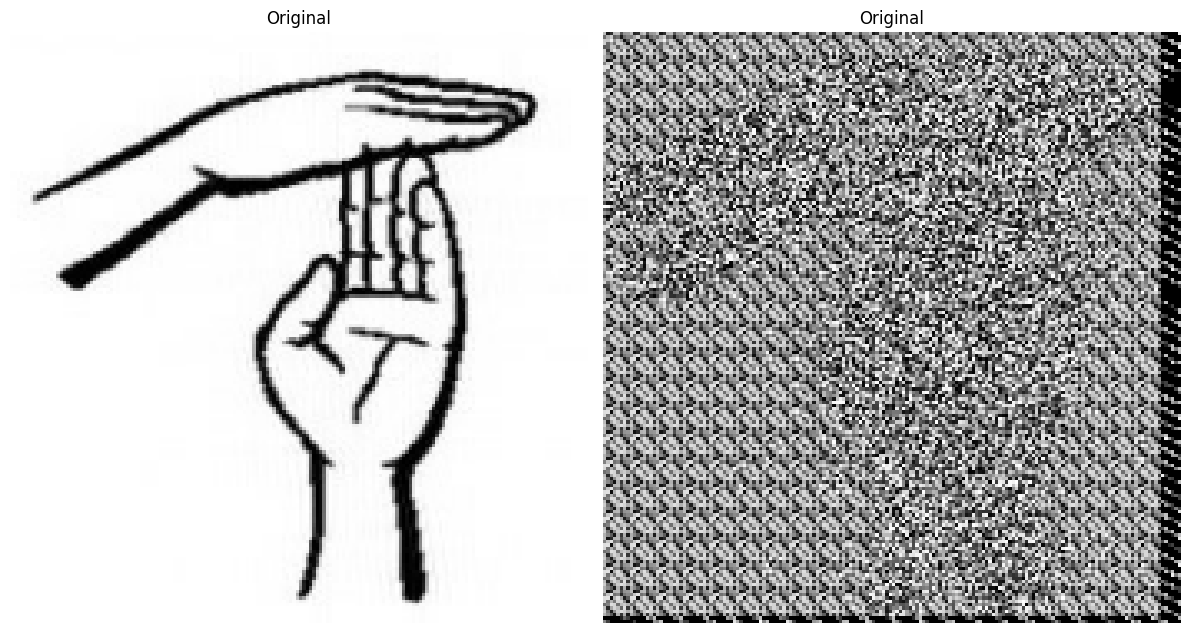

In [13]:
fig = plt.figure(figsize=(12, 10))
# fig , axe = plt.subplots(nrows=2, ncols=3, figsize=(14, 12))
plt.subplot(121);plt.imshow(I, cmap="gray");plt.axis("off");plt.title("Original")
plt.subplot(122);plt.imshow(new_Img, cmap="gray");plt.axis("off");plt.title("Original")
# axe[0, 1].imshow(I, cmap="gray");axe[0, 1].axis("off");axe[0, 1].set_title("Original")
# axe[1, 0].imshow(new_Img_30, cmap="gray");axe[1, 0].axis("off");axe[1, 0].set_title("reconstructed image by energy = 30%")
# plt.subplot(131);plt.imshow(new_Img_30, cmap="gray");plt.axis("off");plt.title("reconstructed image by energy = 30%")
# # axe[1, 1].imshow(new_Img_50, cmap="gray");axe[1, 1].axis("off");axe[1, 1].set_title("reconstructed image by energy = 50%")
# plt.subplot(132);plt.imshow(new_Img_50, cmap="gray");plt.axis("off");plt.title("reconstructed image by energy = 50%")
# # axe[1, 2].imshow(new_Img_70, cmap="gray");axe[1, 2].axis("off");axe[1, 2].set_title("reconstructed image by energy = 70%")
# plt.subplot(133);plt.imshow(new_Img_70, cmap="gray");plt.axis("off");plt.title("reconstructed image by energy = 70%")
plt.tight_layout()
plt.show()

***Apply zig-zag order***

In [14]:
def zigzag(mat):
    index_order = sorted(((x, y) for x in range(8) for y in range(8)), key=lambda x: (x[0] + x[1], -x[1] if (x[0] + x[1]) % 2 else x[1]))
    arr = np.copy(mat)
    order_array = np.zeros((width, height, 64))
    for u in range(width):
        for v in range(height):
            order_array[u, v] = [arr[u, v, i, j] for i, j in index_order]
    return order_array

orderArray = zigzag(qun)

In [143]:
width_o, height_o, deep_o = orderArray.shape
DPCM = np.copy(orderArray)
for x in range(width_o):
    for y in range(height_o) : 
        if x == 0 and y == 0 : DPCM[x, y, 0] = orderArray[x, y, 0]
        elif x == 0 :
            sub = orderArray[x, y - 1, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
        elif y == 0 :
            sub = orderArray[x - 1, y, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
        else:
            sub = orderArray[x - 1, y - 1, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
DPCM = np.round(DPCM)

TypeError: only length-1 arrays can be converted to Python scalars

In [135]:
DPCM[0,0]

array([16192.,     0.,   -24.,    37.,     0.,     0.,     0.,     0.,
           0.,    23.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,    27.,    53.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,   -28.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.])

In [169]:
ac = np.zeros_like(DPCM, dtype=object)
for x in range(width_o):
    for y in range(height_o):
        counter_zero = 0
        for z in range (1, deep_o):
            if DPCM[x, y, z] == 0 : counter_zero+=1;continue
            else: 
                ac[x, y, z] = [(counter_zero, int.bit_length(int(DPCM[x, y, z]))), int(DPCM[x, y, z])]
                counter_zero = 0

In [175]:
ac[3, 3]

array([0, list([(0, 6), 32]), list([(0, 6), 53]), list([(0, 3), -5]),
       list([(0, 5), -27]), list([(0, 3), -5]), list([(0, 4), 15]),
       list([(0, 4), 13]), list([(0, 3), -6]), list([(0, 3), -5]),
       list([(0, 2), 2]), list([(0, 5), 16]), list([(0, 4), -12]),
       list([(0, 5), -20]), list([(0, 4), -15]), list([(0, 4), 13]),
       list([(0, 4), 8]), list([(0, 2), 3]), list([(0, 3), -7]),
       list([(0, 5), -17]), list([(0, 5), -24]), list([(0, 6), 40]),
       list([(0, 6), 44]), list([(0, 6), 42]), list([(0, 5), 30]),
       list([(0, 5), 23]), list([(0, 5), -23]), list([(0, 4), -10]),
       list([(0, 5), 20]), list([(0, 5), 18]), list([(0, 3), 5]),
       list([(0, 6), -38]), list([(0, 7), -89]), list([(0, 6), -54]),
       list([(0, 7), -64]), list([(0, 5), 18]), list([(0, 3), 7]),
       list([(0, 6), 50]), list([(0, 7), 79]), list([(0, 6), 43]),
       list([(0, 6), 39]), list([(0, 4), -8]), list([(0, 4), -11]),
       list([(0, 3), -5]), list([(0, 5), -28]), lis